In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader,TensorDataset
import torch.optim as optim
from dataclasses import dataclass
from typing import List, Tuple, Dict

In [3]:
from biasvariance_toolkit import estimate_bias_variance_mse

In [4]:
import sys
print(sys.executable)

E:\conda_packages\dis_env\python.exe


In [5]:
def generate_sinusoid_data(num_samples:int,noise_scale:float=0.3):
    X = np.linspace(-1,1,num_samples).reshape(-1, 1)
    y_true = np.sin(2 * np.pi * X)                       # shape: (num_samples, 1)
    noise = np.random.normal(0, noise_scale, size=(num_samples, 1))#random gaussian noise
    y = y_true + noise
    return X,y

In [6]:
import torch
import torch.nn as nn

class MLPRegressorKaiming(nn.Module):
    def __init__(self, input_dim, hidden_dim, depth, output_dim=1):
        super().__init__()
        layers = []
        
        # input layer
        layers.append(nn.Linear(input_dim, hidden_dim))
        layers.append(nn.ReLU())
        
        # hidden layers
        for _ in range(depth - 1):
            layers.append(nn.Linear(hidden_dim, hidden_dim))
            layers.append(nn.ReLU())
        
        # output layer
        layers.append(nn.Linear(hidden_dim, output_dim))
        self.net = nn.Sequential(*layers)
        
        # Apply Kaiming initialization
        self.apply(self._init_weights)
        
    def _init_weights(self, m):
        if isinstance(m, nn.Linear):
            nn.init.kaiming_uniform_(m.weight, nonlinearity="relu")
            nn.init.zeros_(m.bias)
    
    def forward(self, x):
        return self.net(x)

# Example usage
mlp = MLPRegressorKaiming(input_dim=10, hidden_dim=64, depth=4)
print(mlp)


MLPRegressorKaiming(
  (net): Sequential(
    (0): Linear(in_features=10, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=64, bias=True)
    (5): ReLU()
    (6): Linear(in_features=64, out_features=64, bias=True)
    (7): ReLU()
    (8): Linear(in_features=64, out_features=1, bias=True)
  )
)


In [7]:
# class MLP(nn.Module):
#     def __init__(self, in_dim=1, hidden=128, depth=1):
#         super().__init__()
#         layers = []
#         layers.append(nn.Linear(in_dim, hidden))
#         layers.append(nn.ReLU())
#         for _ in range(depth-1):
#             layers.append(nn.Linear(hidden, hidden))
#             layers.append(nn.ReLU())
#         layers.append(nn.Linear(hidden, 1))
#         self.net = nn.Sequential(*layers)
#     def forward(self, x):
#         return self.net(x)

In [8]:
@dataclass
class TrainConfig:
    batch_size: int = 128
    epochs: int = 300
    lr: float = 3e-3
    weight_decay: float = 1e-3
    grad_clip: float = 1.0
    early_stop_patience: int = 30
    device: str = "cpu"
    seed: int = 42

In [7]:
NUM_TRAIN_SAMPLES = 1000
NUM_TEST_SAMPLES = 5000
BOOTSTRAP_NUMS = 30
MAX_EPOCHS = 500
PATIENCE = 500
LEARNING_RATE=0.001

In [8]:
depths=[1, 2, 4, 8, 16, 32,64]

In [9]:
X_train,y_train = generate_sinusoid_data(num_samples=NUM_TRAIN_SAMPLES)
X_test,y_test = generate_sinusoid_data(num_samples=NUM_TEST_SAMPLES,noise_scale=0)

In [10]:
hidden_units=128
depth_results= []
for d in depths:
    print(f"\n*** Running experiment for network with {d} depth***")
    bias_sq, variance, total_error,error_sum,avg_train_loss,test_loss = estimate_bias_variance_mse(
            model_class=MLPRegressorKaiming,
            X_train=X_train,
            y_train=y_train,
            X_test=X_test,
            y_test=y_test,
            loss_fn=nn.MSELoss(),
            model_kwargs={'input_dim':X_train.shape[1],"hidden_dim":128,'depth':d},
            num_models=30,
            max_epochs=MAX_EPOCHS,
            patience=PATIENCE,
            lr=LEARNING_RATE,
            batch_size=64
        )
    depth_results.append({
            'depth': d,
            'bias_sq': bias_sq,
            'variance': variance,
            'total_error': total_error,
            'error_sum': error_sum,
            'avg_train_loss':avg_train_loss,
            'test_loss':test_loss
        })



*** Running experiment for network with 1 depth***

--- Training Model 1/30 ---

--- Training Model 2/30 ---

--- Training Model 3/30 ---

--- Training Model 4/30 ---

--- Training Model 5/30 ---

--- Training Model 6/30 ---

--- Training Model 7/30 ---

--- Training Model 8/30 ---

--- Training Model 9/30 ---

--- Training Model 10/30 ---

--- Training Model 11/30 ---

--- Training Model 12/30 ---

--- Training Model 13/30 ---

--- Training Model 14/30 ---

--- Training Model 15/30 ---

--- Training Model 16/30 ---

--- Training Model 17/30 ---

--- Training Model 18/30 ---

--- Training Model 19/30 ---

--- Training Model 20/30 ---

--- Training Model 21/30 ---

--- Training Model 22/30 ---

--- Training Model 23/30 ---

--- Training Model 24/30 ---

--- Training Model 25/30 ---

--- Training Model 26/30 ---

--- Training Model 27/30 ---

--- Training Model 28/30 ---

--- Training Model 29/30 ---

--- Training Model 30/30 ---

--- MSE Decomposition Results ---
Bias²              : 0

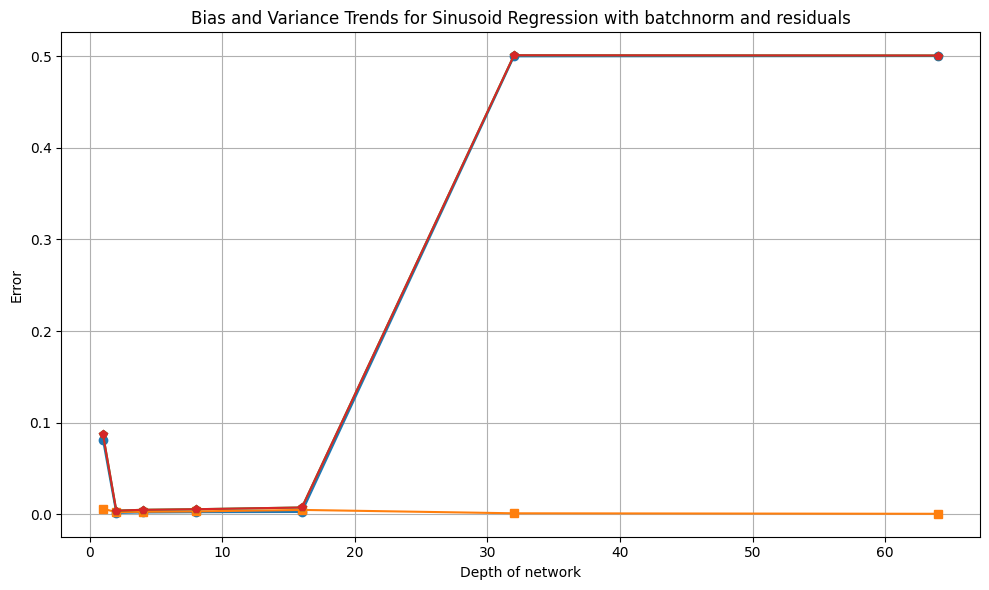

In [15]:
bias_values = [res['bias_sq'] for res in depth_results]
variance_values = [res['variance'] for res in depth_results]
error_values = [res['total_error'] for res in depth_results]
bias_plus_variance = [res['error_sum'] for res in depth_results]
    
plt.figure(figsize=(10, 6))
plt.plot(depths, bias_values, marker='o', label='Bias')
plt.plot(depths, variance_values, marker='s', label='Variance')
plt.plot(depths, error_values, marker='p', label='total error')
plt.plot(depths, bias_plus_variance, marker='p', label='bias + variance')

    
# plt.xscale('log')
plt.xlabel('Depth of network')
plt.ylabel('Error')
plt.title('Bias and Variance Trends for Sinusoid Regression with batchnorm and residuals')
plt.legend()
plt.grid(True)
plt.tight_layout()

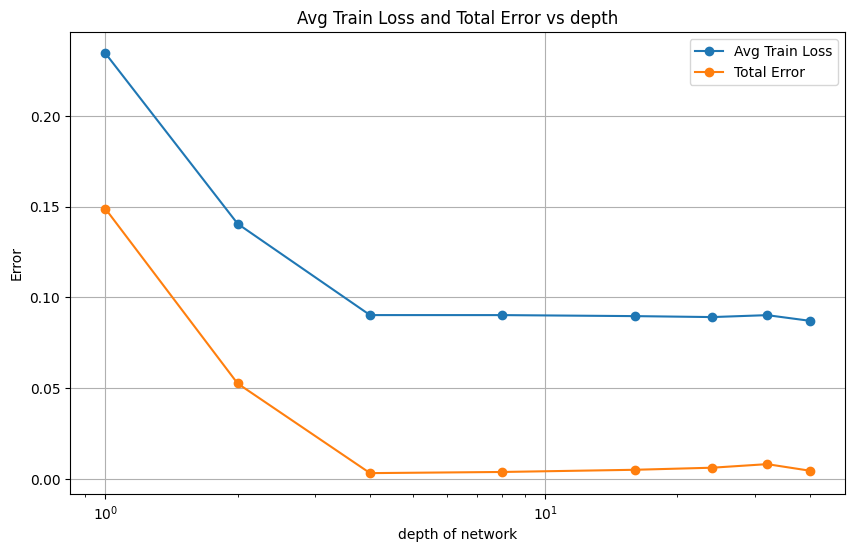

In [54]:
test_loss = [r['total_error'] for r in depth_results]
avg_train_loss = [r['avg_train_loss'] for r in depth_results]

plt.figure(figsize=(10, 6))
plt.plot(depths, avg_train_loss, marker='o', label='Avg Train Loss')
plt.plot(depths, test_loss, marker='o', label='Total Error')
plt.xscale('log')  # Log scale for hidden units
plt.xlabel('depth of network')
plt.ylabel('Error')
plt.title('Avg Train Loss and Total Error vs depth')
plt.legend()
plt.grid(True)
plt.show()


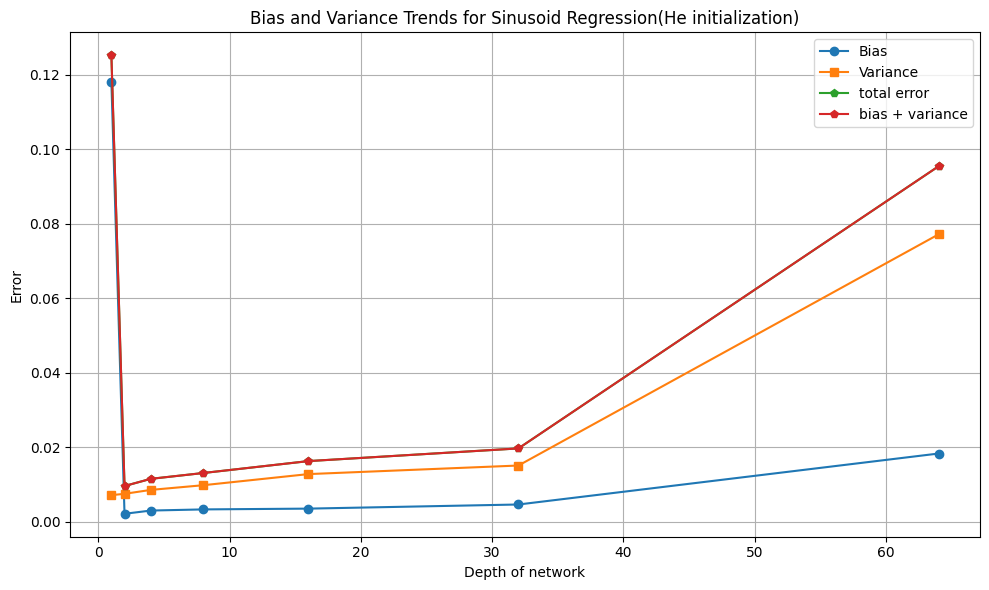

In [14]:
bias_values = [res['bias_sq'] for res in depth_results]
variance_values = [res['variance'] for res in depth_results]
error_values = [res['total_error'] for res in depth_results]
bias_plus_variance = [res['error_sum'] for res in depth_results]
    
plt.figure(figsize=(10, 6))
plt.plot(depths, bias_values, marker='o', label='Bias')
plt.plot(depths, variance_values, marker='s', label='Variance')
plt.plot(depths, error_values, marker='p', label='total error')
plt.plot(depths, bias_plus_variance, marker='p', label='bias + variance')

    
#plt.xscale('log')
plt.xlabel('Depth of network')
plt.ylabel('Error')
plt.title('Bias and Variance Trends for Sinusoid Regression(He initialization)')
plt.legend()
plt.grid(True)
plt.tight_layout()

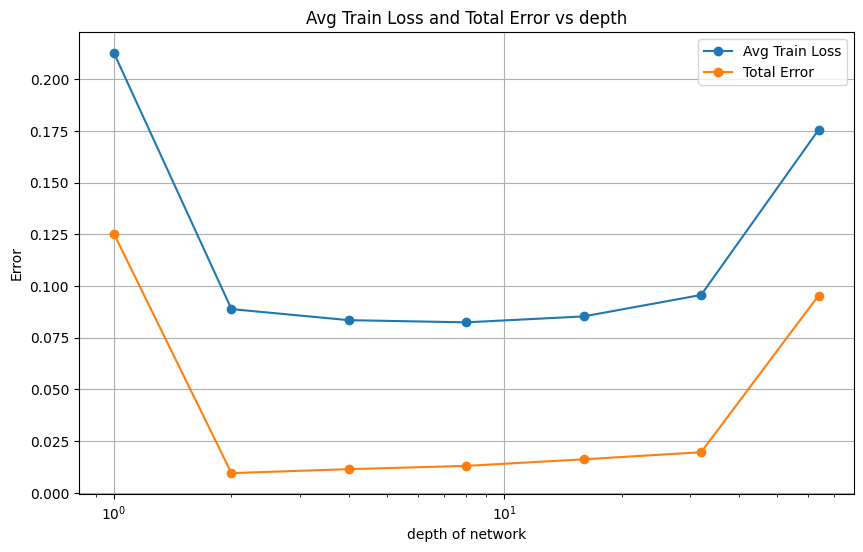

In [12]:
test_loss = [r['total_error'] for r in dataset_results]
avg_train_loss = [r['avg_train_loss'] for r in dataset_results]

plt.figure(figsize=(10, 6))
plt.plot(num_samples, avg_train_loss, marker='o', label='Avg Train Loss')
plt.plot(num_samples, test_loss, marker='o', label='MSE')
plt.xscale('log')  # Log scale for hidden units
plt.xlabel('depth of network')
plt.ylabel('Error')
plt.title('Avg Train Loss and Total Error vs depth')
plt.legend()
plt.grid(True)
plt.show()


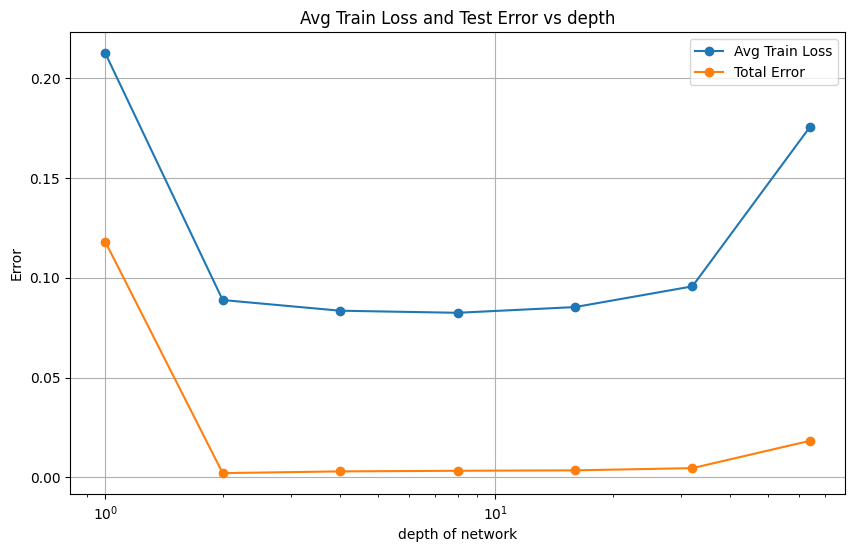

In [15]:
test_loss = [r['test_loss'] for r in depth_results]
avg_train_loss = [r['avg_train_loss'] for r in depth_results]

plt.figure(figsize=(10, 6))
plt.plot(depths, avg_train_loss, marker='o', label='Avg Train Loss')
plt.plot(depths, test_loss, marker='o', label='Total Error')
plt.xscale('log')  # Log scale for hidden units
plt.xlabel('depth of network')
plt.ylabel('Error')
plt.title('Avg Train Loss and Test Error vs depth')
plt.legend()
plt.grid(True)
plt.show()


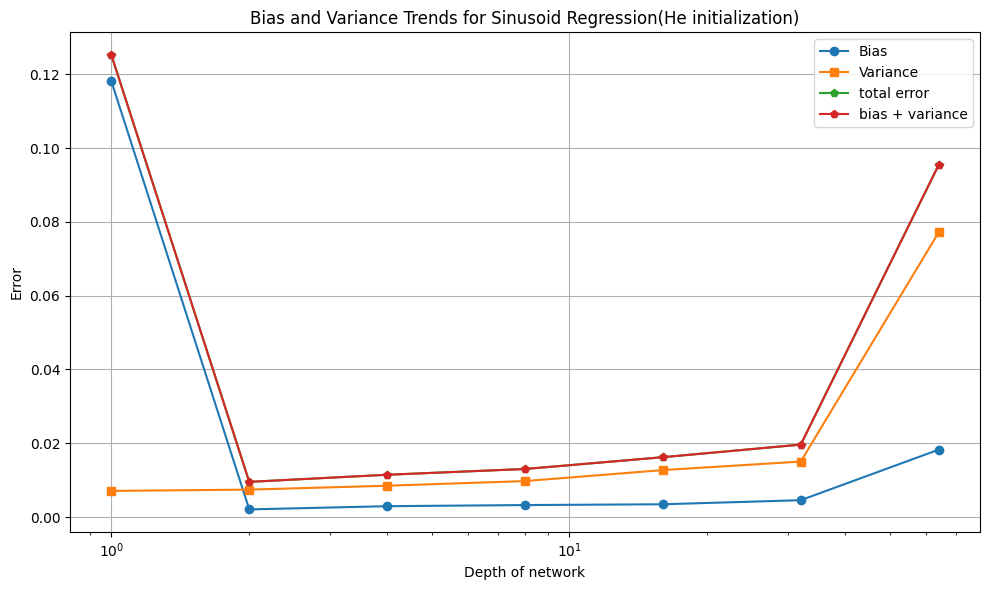

In [16]:
bias_values = [res['bias_sq'] for res in depth_results]
variance_values = [res['variance'] for res in depth_results]
error_values = [res['total_error'] for res in depth_results]
bias_plus_variance = [res['error_sum'] for res in depth_results]
    
plt.figure(figsize=(10, 6))
plt.plot(depths, bias_values, marker='o', label='Bias')
plt.plot(depths, variance_values, marker='s', label='Variance')
plt.plot(depths, error_values, marker='p', label='total error')
plt.plot(depths, bias_plus_variance, marker='p', label='bias + variance')

    
plt.xscale('log')
plt.xlabel('Depth of network')
plt.ylabel('Error')
plt.title('Bias and Variance Trends for Sinusoid Regression(He initialization)')
plt.legend()
plt.grid(True)
plt.tight_layout()